# Projecto de Neurociencias
## Clasificador de tumores de alto y bajo grado
### Integrantes del equipo: Alfonso Toriz Vázquez, Michelle Dubhé Mata Hernández, Xiao Wei Zhou, André Mendez Vera, Valeria Valenzuela López y Gerardo De Jesús Navarrete

#### Importamos las librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from mahotas.texture import haralick
import os
from glob import glob
from itkwidgets import view
import json
from skimage.measure import regionprops
import pandas as pd

#### Exploramos los archivos
Utilizaremos un diccionario para organizar los archivos en diferentes categorías:
* Grado del Tumor (HG, LG)
    * Número de Caso
        * Tipo de Imagen [Flair, T1, T1c, T2, Máscaras]

In [126]:
# Directorio base
path = "/home/atoriz98/Datasets/BrainGliomas/GliomasImages"

files = glob(path + "/**/*.mha", recursive=True)

# Dictionaries and list to organize files
Dataset = {'HG': {}, 'LG': {}}
id_HG = np.asarray([])
id_LG = np.asarray([])

# Image types
types = ['Flair', 'T1', 'T1c', 'T2', 'OT']

In [127]:
# Add cases names
for file in files:
    if 'HG' in file:
        id_HG = np.append(id_HG, file.split('/')[7])
    else:
        id_LG = np.append(id_LG, file.split('/')[7])

# Find all unique values of cases
for unique in np.unique(id_HG):
    Dataset['HG'][unique] = {}
    for img in types:
        Dataset['HG'][unique][img] = {}
for unique in np.unique(id_LG):
    Dataset['LG'][unique] = {}
    for img in types:
        Dataset['LG'][unique][img] = {}

# Fill Dataset dictionary accordingly
for grade in Dataset.keys():  # HG LG
    for case in Dataset[grade].keys():  # Num
        for img in types:  # Flair, Tc1, Tc2 ...
            for file in files:
                route = file.split('/')
                if route[6] == grade and route[7] == case and route[8].endswith(img):
                    Dataset[grade][case][img] = file

#### Imprimimos nuestro diccionario organizado

In [11]:
# Print Dataset for easy reading
print(json.dumps(Dataset, indent=4))

{
    "HG": {
        "0001": {
            "Flair": "/home/atoriz98/Datasets/BrainGliomas/GliomasImages/HG/0001/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.684.mha",
            "T1": "/home/atoriz98/Datasets/BrainGliomas/GliomasImages/HG/0001/VSD.Brain.XX.O.MR_T1/VSD.Brain.XX.O.MR_T1.685.mha",
            "T1c": "/home/atoriz98/Datasets/BrainGliomas/GliomasImages/HG/0001/VSD.Brain.XX.O.MR_T1c/VSD.Brain.XX.O.MR_T1c.686.mha",
            "T2": "/home/atoriz98/Datasets/BrainGliomas/GliomasImages/HG/0001/VSD.Brain.XX.O.MR_T2/VSD.Brain.XX.O.MR_T2.687.mha",
            "OT": "/home/atoriz98/Datasets/BrainGliomas/GliomasImages/HG/0001/VSD.Brain_3more.XX.XX.OT/VSD.Brain_3more.XX.XX.OT.6560.mha"
        },
        "0002": {
            "Flair": "/home/atoriz98/Datasets/BrainGliomas/GliomasImages/HG/0002/VSD.Brain.XX.O.MR_Flair/VSD.Brain.XX.O.MR_Flair.691.mha",
            "T1": "/home/atoriz98/Datasets/BrainGliomas/GliomasImages/HG/0002/VSD.Brain.XX.O.MR_T1/VSD.Brain.XX.O.MR_T1.692.mha",


#### Visualizamos los ids de casos de HG y LG

In [103]:
print("Los casos de tumores de alto grado (HG) son: {}".format(np.unique(id_HG)))

Los casos de tumores de alto grado (HG) son: ['0001' '0002' '0003' '0004' '0005' '0006' '0007' '0008' '0009' '0010'
 '0011' '0012' '0013' '0014' '0015' '0022' '0024' '0025' '0026' '0027']


In [104]:
print("Los casos de tumores de bajo grado (LG) son: {}".format(np.unique(id_LG)))

Los casos de tumores de bajo grado (LG) son: ['0001' '0002' '0004' '0006' '0008' '0011' '0012' '0013' '0014' '0015']


#### Definimos funciones de ayuda

In [132]:
def myshow(img):
    nda = sitk.GetArrayViewFromImage(img)
    plt.imshow(nda)

def Get_MRI_Image(Grade, id_Case, Type):
    """[summary]
        Get ITK MRI Image array from dictionary
    Args:
        Grade ([string]): String specifying HG or LG.
        id_Case ([string]): String specifying the number of case.
        Type ([string]): String specifying the Image type.
    Returns:
        itk.itkImagePython.itkImageSS3
    """
    return sitk.ReadImage(Dataset[Grade][id_Case][Type])

def disp_MRI_Case_Slices(Grade, case, axis, Slice, fig_size, rows, cols):
    """[summary]
        Allows to display multiple images along with their title.
        Doesn't contain axis labels and the default cmap = 'gray'.
    Args:
        Grade ([str]): Tumor Type
        case ([str]): Case number
        axis ([int]): int between 0 and 2 specifying display axis.
        Slice ([int]): Number of slice to display.
        fig_size ([tuple]): Figure size, self-explanatory.
        rows ([type]): number of rows of the figure.
        cols ([type]): number of colums of the figure.
    """
    if axis == 0:
        slice_obj = np.s_[Slice, :, :]
    elif axis == 1:
        slice_obj = np.s_[:, Slice, :]
    else:
        slice_obj = np.s_[:, :, Slice]

    images = []
    titles = np.asarray([])

    for types in Dataset[Grade][case]:
        titles = np.append(titles, types)
        img = sitk.ReadImage(Dataset[Grade][case][types])
        img = sitk.GetArrayFromImage(img)
        images.append(img[slice_obj])

    fig = plt.figure(figsize=fig_size)
    for position in range(len(images)):
        fig.add_subplot(rows, cols, position+1)
        plt.imshow(images[position], cmap='gray')
        plt.axis('off')
        plt.title(titles[position])
    
def MRI_Case(Grade, case):
    """[summary]
        Returns list with available mha for the case.
    Args:
        Grade ([str]): Tumor Type
        case ([str]): Case number
    """
    images = []

    for types in Dataset[Grade][case]:
        img = sitk.ReadImage(Dataset[Grade][case][types])
        images.append(img)

    return images


def Normalize_255(mha):
    """[summary]
        Returns an itk image normalize a range of [0 255]
    Args:
        mha ([itkImage]): Image
    """
    mha = sitk.Cast(mha,sitk.sitkFloat32)
    MaxMin = sitk.MinimumMaximumImageFilter()
    MaxMin.Execute(mha)
    
    max_val = MaxMin.GetMaximum()
    mha = mha/max_val * 255
    
    mha = sitk.Cast(mha, sitk.sitkUInt8)
    
    return mha

def Extract_ROI(vol, msk):
    """[summary]
        Returns an itk image normalize a range of [0 255]
    Args:
        mha ([itkImage]): Image
    """
    volume = vol
    roi = sitk.Cast(msk, sitk.sitkUInt8)
    roi_np = sitk.GetArrayFromImage(roi)
    #
    #try:
    roi = (roi == np.unique(roi_np)[1]) + (roi == np.unique(roi_np)[-1])
    #except:
        #roi = (roi == np.unique(roi_np)[1]) + (roi == np.unique(roi_np)[-1])
     
    #
    extraction = sitk.MaskImageFilter()
    extraction.SetMaskingValue(MaskingValue=0)
    extraction.SetOutsideValue(1)
    extracted = extraction.Execute(volume, roi)
    
    return extracted

def Delete_extra_space(tumor_vol):
    """[summary]
        Removes extra 2D arrays from 3D arrays based on list comprehensions
    Args:
        tumor_vol ([ndarray): numpy array
    """
    tumor_vol = sitk.GetArrayFromImage(tumor_vol)
    m,n,p = tumor_vol.shape
    m_id = [i for i in range(m) if np.any(tumor_vol[i,:,:] != 1)]
    n_id = [j for j in range(n) if np.any(tumor_vol[:,j,:] != 1)]
    p_id = [k for k in range(p) if np.any(tumor_vol[:,:,k] != 1)]
    
    return (tumor_vol[m_id[0]:m_id[-1], n_id[0]:n_id[-1], p_id[0]:p_id[-1]])

def Extract_Caract(roi):
    """[summary]
        Returns list with available mha for the case.
    Args:
        Grade ([str]): Tumor Type
        case ([str]): Case number
    """
    data = []
    m,n,p = roi.shape
    
    # Extract_Caract
    names = ['Angular Second Moment','Contrast','Correlation','Variance','Inverse Difference Moment',
                  'Sum Average','Sum Variance','Sum Entropy','Entropy','Difference Variance',
                  'Difference Entropy','Info Correlation 1','Info Correlation 2', 'Area', 'Eccentricity',
                  'Perimeter', 'Grade']
    
    for i in range(5,m-5):
        caract = haralick(roi[i, :, :], distance=1, return_mean=True)
        region_props = regionprops(roi[i, :, :].astype(np.uint0))[0]
        caract = np.append(caract, [region_props.area, region_props.eccentricity , region_props.perimeter, Grade])
        data.append(caract)
    
    data_arr = np.array(data)
    df = pd.DataFrame(data_arr, columns = names)
    
    return (df)

In [57]:
vol = Get_MRI_Image('HG', '0002', 'Flair')
msk = Get_MRI_Image('HG', '0002', 'OT')
vol_norm = Normalize_255(vol)
if vol_norm.GetOrigin() != msk.GetOrigin():
    vol_norm.SetOrigin(msk.GetOrigin())
extracted = Extract_ROI(vol_norm, msk)

In [ ]:
view(vol_norm)

In [ ]:
view(extracted)

#### Cargamos todas las imágenes de de tumor de alto grado 0001 para observar y compararlas

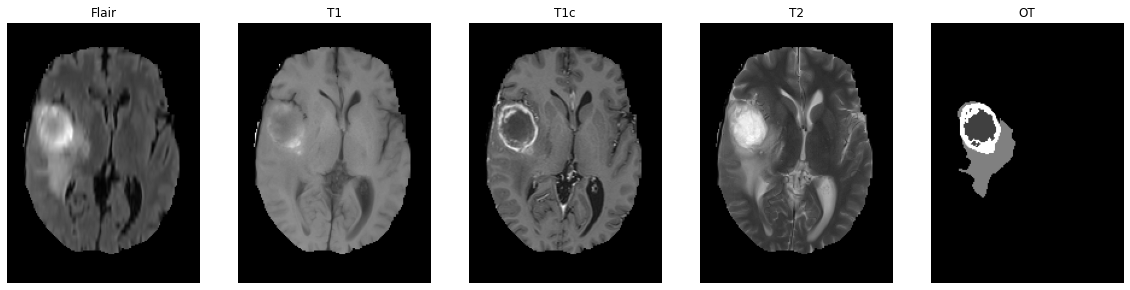

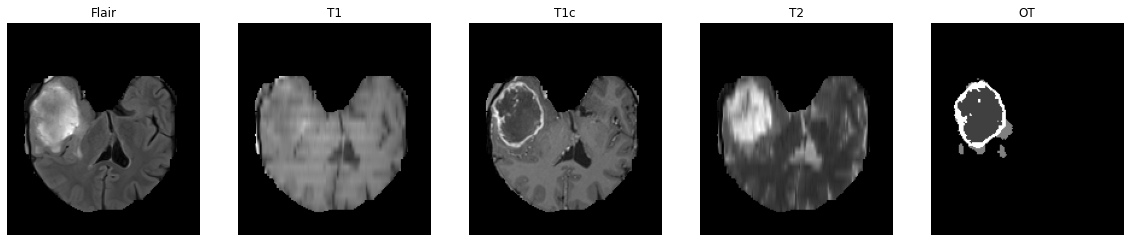

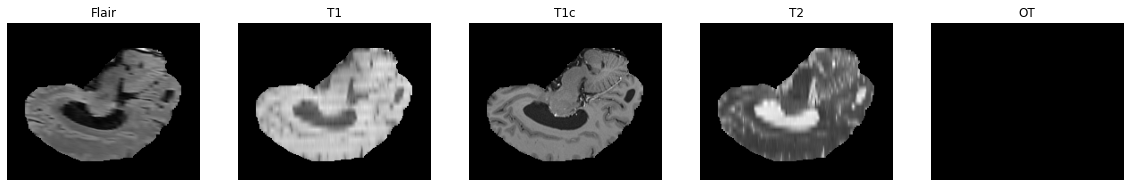

In [7]:
disp_MRI_Case_Slices('HG', '0001', axis=0, Slice=90, fig_size=(20, 10), rows=1, cols=5)
disp_MRI_Case_Slices('HG', '0001', axis=1, Slice=90, fig_size=(20, 10), rows=1, cols=5)
disp_MRI_Case_Slices('HG', '0001', axis=2, Slice=90, fig_size=(20, 10), rows=1, cols=5)

#### Cargamos todas las imágenes de de tumor de bajo grado 0001 para observar y compararlas

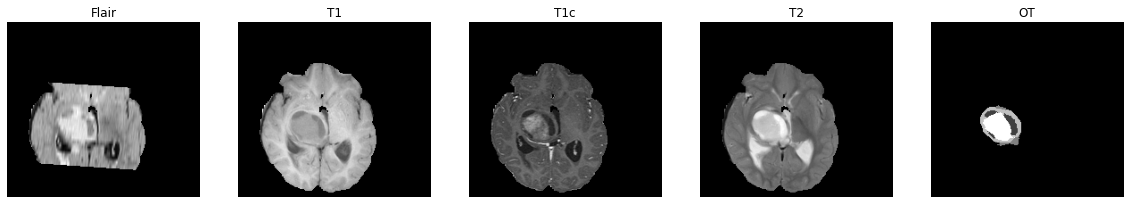

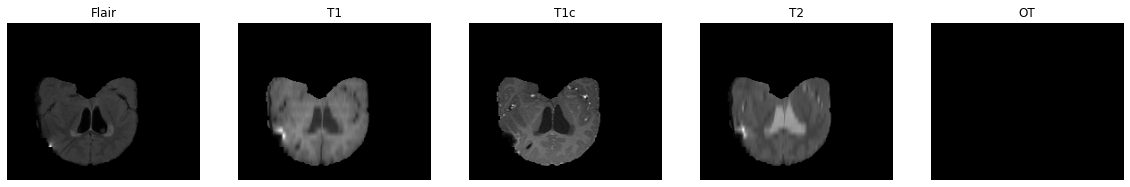

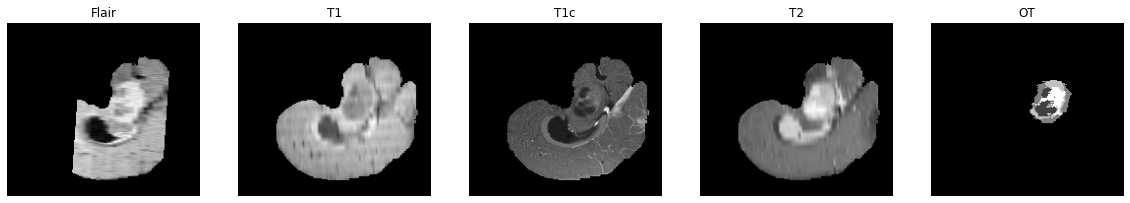

In [8]:
disp_MRI_Case_Slices('LG', '0001', axis=0, Slice=90, fig_size=(20, 10), rows=1, cols=5)
disp_MRI_Case_Slices('LG', '0001', axis=1, Slice=90, fig_size=(20, 10), rows=1, cols=5)
disp_MRI_Case_Slices('LG', '0001', axis=2, Slice=90, fig_size=(20, 10), rows=1, cols=5)

In [106]:
HG_0001_imgs = MRI_Case('HG','0001')

In [107]:
HG_0001_Flair_itk = HG_0001_imgs[0]

In [65]:
HG_0001_Flair_itk.GetSize()

(216, 236, 176)

#### Normalizamos los valores de la imagen a [0 255]

In [108]:
HG_0001_Flair_itk = Normalize_255(HG_0001_Flair_itk)

In [109]:
view(HG_0001_Flair_itk)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

La variable necesita convertirse a un array de numpy para manipularse con mayor facilidad

In [13]:
type(HG_0001_Flair_itk)

SimpleITK.SimpleITK.Image

In [67]:
HG_0001_Flair_itk_np = sitk.GetArrayFromImage(HG_0001_Flair_itk)

In [13]:
type(HG_0001_Flair_itk_np)

numpy.ndarray

#### Mostramos un corte

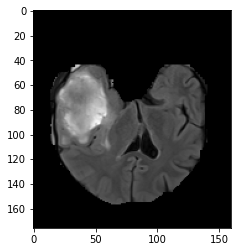

In [15]:
slice_90 = HG_0001_Flair_itk_np[: , 90, :]
plt.imshow(slice_90, cmap='gray')

In [16]:
# MxN dimensions
slice_90.shape

(176, 160)

In [17]:
slice_90

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

#### Graficamos el histograma del corte

In [18]:
hist = cv2.calcHist([slice_90],[0],None,[256],[0,256])

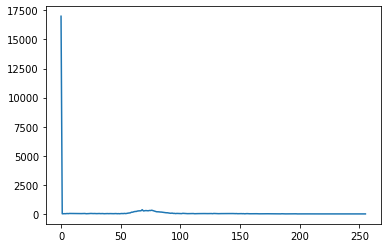

In [19]:
plt.plot(hist)

Pareciera ser que el negro del fondo (0) está opacando a las demás intensidades, vamos a ignorarlo y volver a graficar

In [20]:
hist = cv2.calcHist([slice_90],[0],None,[256],[1,256])

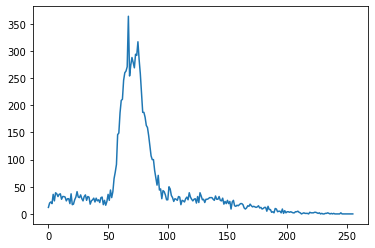

In [21]:
plt.plot(hist)

### Ahora veremos la máscara que le corresponde

In [110]:
mask = sitk.Cast(HG_0001_imgs[-1], sitk.sitkUInt8) # Adjust type to match

In [111]:
view(mask)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

### Todas las máscaras tienen 4 niveles de intensidad. Cada uno le corresponde a de las siguientes clases:
1. necrosis 
2. edema 
3. region sin contraste 
4. Region activa (contrastada)

In [23]:
m_slice_90 = sitk.GetArrayFromImage(mask)

In [24]:
m_slice_90 = m_slice_90[:, 90, :]

In [25]:
np.unique(m_slice_90)

array([0, 1, 2, 3, 4], dtype=uint8)

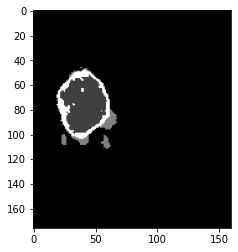

In [26]:
plt.imshow(m_slice_90,cmap='gray')

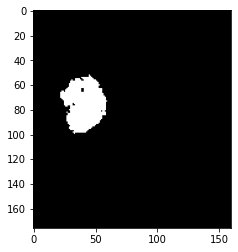

In [27]:
plt.imshow(m_slice_90==1,cmap='gray')

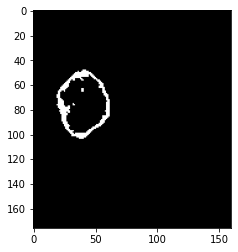

In [28]:
plt.imshow(m_slice_90==4,cmap='gray')

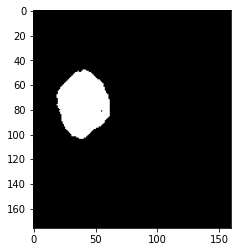

In [29]:
plt.imshow(np.logical_or(m_slice_90==1,m_slice_90==4),cmap='gray')

### Sumaremos la parte necrosada con la activa para obtener una imagen más completa del tumor

#### Visualizamos

In [30]:
mask2 = (mask==1) + (mask==4)

In [215]:
mask2 = (mask==1) + (mask==3)

In [216]:
view(mask2)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

In [31]:
m_slice_902 = sitk.GetArrayFromImage(mask2)

In [32]:
m_slice_902 = m_slice_902[:, 90, :]

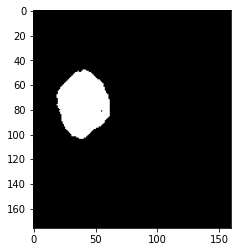

In [33]:
plt.imshow(m_slice_902, cmap='gray')

### A continuación, extraeremos la región de interés (ROI) de nuestro volumen original

In [112]:
ROI = Extract_ROI(HG_0001_Flair_itk,mask)

In [113]:
view(ROI)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

### Visualizamos algunos cortes

In [85]:
ROI_np = sitk.GetArrayFromImage(ROI)

In [86]:
ROI_np.shape

(176, 236, 216)

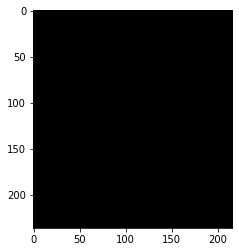

In [87]:
plt.imshow(ROI_np[50,:,:],cmap='gray')

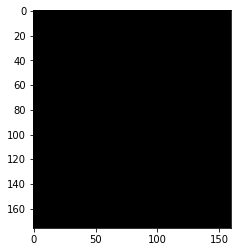

In [39]:
plt.imshow(ROI_np[:,50,:],cmap='gray')

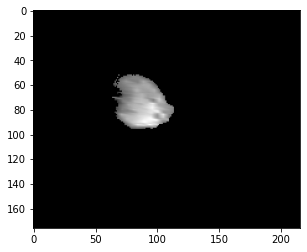

In [40]:
plt.imshow(ROI_np[:,:,50],cmap='gray')

#### Aún nos falta eliminar los cortes completamente negros

In [88]:
ROI_np = Delete_extra_space(ROI)

In [89]:
ROI_np.shape

(21, 28, 30)

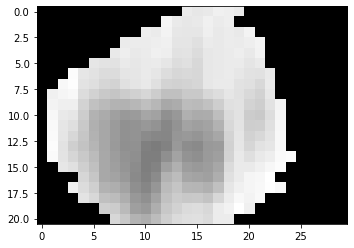

In [90]:
plt.imshow(ROI_np[:,20,:],cmap='gray')

In [91]:
view(sitk.GetImageFromArray(ROI_np))

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itk.itkImagePython.itkImageUC3; pr…

### Sólo nos resta obtener las características de textura

In [130]:
data = []
for Grade in Dataset.keys():
    for Case in Dataset[Grade].keys():
        vol = Get_MRI_Image(Grade, Case, 'Flair')
        msk = Get_MRI_Image(Grade, Case, 'OT')
        
        vol_norm = Normalize_255(vol)
        
        # Ajustamos los orígenes de los volúmenes
        if vol_norm.GetOrigin() != msk.GetOrigin():
            vol_norm.SetOrigin(msk.GetOrigin())
        extracted = Extract_ROI(vol_norm, msk)
        
        print('{}:{}'.format(Grade, Case))
        #print('Las dimensiones del volumen y máscara son iguales? R={}'.format(vol_norm.GetSize() == msk.GetSize()))
        #print('Los orígenes del volumen y máscara son iguales? R={}'.format(vol_norm.GetOrigin() == msk.GetOrigin())) # Los orígenes no coinciden, por eso no se puede extraer la ROI
        
        roi = Delete_extra_space(extracted)
        data.append(Extract_Caract(roi))
data = pd.concat(data)

HG:0001
HG:0002
HG:0003
HG:0004
HG:0005
HG:0006
HG:0007
HG:0008
HG:0009
HG:0010
HG:0011
HG:0012
HG:0013
HG:0014
HG:0015
HG:0022
HG:0024
HG:0025
HG:0026
HG:0027
LG:0001
LG:0002
LG:0004
LG:0006
LG:0008
LG:0011
LG:0012
LG:0013
LG:0014
LG:0015


In [131]:
data

,Angular Second Moment,Contrast,Correlation,Variance,Inverse Difference Moment,Sum Average,Sum Variance,Sum Entropy,Entropy,Difference Variance,Difference Entropy,Info Correlation 1,Info Correlation 2,Area,Eccentricity,Perimeter,Convex_area,Grade
0,0.6871004963989823,277.4624802920614,0.9307792241180202,2001.0585082816694,0.8459521168329209,39.82167440243565,7726.771552834615,1.9122270360956846,2.2516633192345497,0.0037136581288765326,1.481631077529586,-0.6198479210792709,0.9312770029819057,2204,0.7390431537684827,294.84062043356596,2604,HG
1,0.6362486957394609,264.41126560128635,0.943300943548629,2327.802020391491,0.8229112243868465,47.295280965954625,9046.79681596468,2.228770386183108,2.647712023744341,0.003160309804435078,1.6573666162038083,-0.6217961314260361,0.9529163899452086,2124,0.7411334372315144,292.42640687119285,2604,HG
2,0.5670727706425351,333.709968393595,0.9355879545652277,2586.3882207783486,0.7884005776433098,56.581870477615404,10011.842914719799,2.6275866575992897,3.186438936791084,0.0031934964414770985,1.912594909350492,-0.5814601013020576,0.9623358096862121,2017,0.7447700019594039,305.01219330881975,2604,HG
3,0.5198462226974307,386.94326186576063,0.9306397136403846,2785.8978453605732,0.7640345593093797,63.44745481223793,10756.64811957653,2.9079374574927894,3.5455905135070362,0.003171994675596206,2.0603472150105464,-0.5610857322497455,0.9676946934349382,1943,0.7465896924319626,314.7045814642449,2604,HG
4,0.4606074263287946,355.85176420983066,0.943035107572572,3119.528263558251,0.7287567591754364,73.96196421584975,12122.261290023176,3.286086803975939,4.049815548977214,0.002752153674268879,2.285531189515002,-0.5549626053841108,0.9772645687898189,1835,0.7531516270979689,324.7401153701776,2604,HG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,0.19856300907416952,1130.8816013477244,0.9159457026931666,6728.236603694924,0.5310361794828742,172.2152514833674,25782.06481343196,5.002358988193636,6.400581064492215,0.0012162964218193574,3.4343276581398774,-0.46985833331702365,0.9897793928029996,837,0.5843738404269981,282.12489168102786,1702,LG
27,0.2165124722683284,1185.8408100129113,0.9152228816674257,6993.91301378418,0.5488920658505654,169.5506076728903,26789.8112451238,4.743320943142671,6.081578876667686,0.0012954228601330013,3.279198471401263,-0.46967530047655415,0.987496247059406,869,0.5974348776231533,278.77564927611036,1702,LG
28,0.22878736994016724,1204.8914579434506,0.914324153704642,7030.873624685962,0.5729872648921381,165.9908386647517,26918.6030408004,4.58969114130393,5.865015173202069,0.0014200077315815068,3.155959893963357,-0.46220355373509453,0.9845517315583288,892,0.6022330010899554,283.39696961966996,1702,LG
29,0.2850671463796214,1178.8820773672223,0.9151160476293965,6940.2349426721585,0.6179423478390639,148.36272595058824,26582.057693321418,4.18377394448372,5.290490170821901,0.0016429367066530913,2.9279836426858004,-0.4725894246349188,0.9802874559881053,981,0.578291199699741,279.6396103067893,1702,LG


In [97]:
data.to_csv('Dataset_Gliomas.csv')

In [133]:
data = pd.read_csv('Dataset_Gliomas.csv')

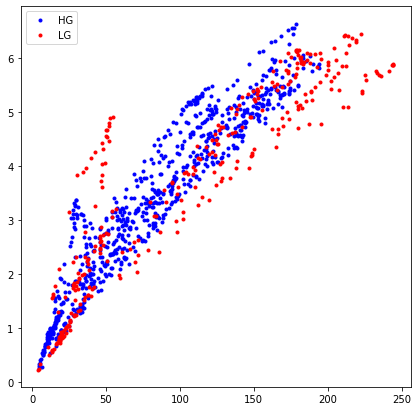

In [140]:
#Visualización de características en 2 dimensiones
caract1 = 'Sum Average'
caract2 = 'Sum Entropy'

hg = data[data.Grade=='HG']
lg = data[data.Grade=='LG']

plt.figure(figsize=(7,7))
plt.plot(hg[caract1], hg[caract2], 'b.', label='HG')
plt.plot(lg[caract1], lg[caract2], 'r.', label='LG')
plt.legend()
plt.show()

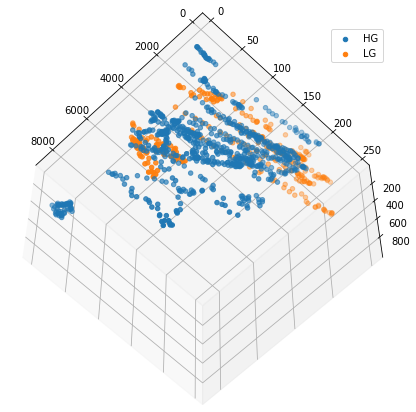

In [146]:
#Visualización de características en 3 dimensiones
from mpl_toolkits.mplot3d import Axes3D

caract1 = 'Area'
caract2 = 'Sum Average'
caract3 = 'Perimeter'


rot_y = 120
rot_x = 45
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(rot_y, rot_x)
ax.scatter(hg[caract1], hg[caract2], hg[caract3], 'b.', label='HG')
ax.scatter(lg[caract1], lg[caract2], lg[caract3], 'r.', label='LG')

plt.legend()
plt.show()

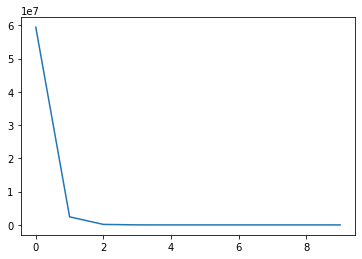

In [149]:
from sklearn.decomposition import PCA

#Se seleccionan los datos de nuestro DataFrame
X = data.iloc[:,:-1]
y = data.Grade

#Se indica el número de componentes a conservar
n_componentes = 10
pca = PCA(n_components = n_componentes)
X = pca.fit_transform(X)

plt.plot(pca.explained_variance_)
plt.show()

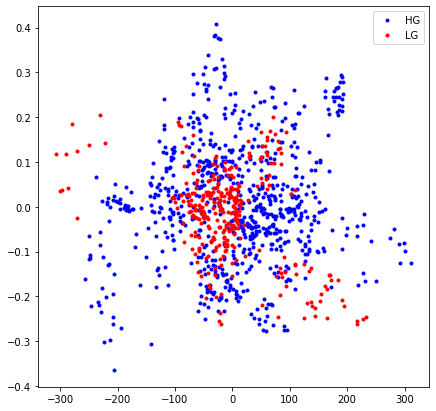

In [219]:
#Visualización de los dos primeros componentes
hg = X[y=='HG']
lg = X[y=='LG']

plt.figure(figsize=(7,7))
plt.plot(hg[:, 3], hg[:, 8], 'b.', label='HG')
plt.plot(lg[:, 3], lg[:, 8], 'r.', label='LG')
plt.legend()

plt.show()

In [ ]:
rot_y = 120
rot_x = 45
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(rot_y, rot_x)
ax.scatter(hg[:, 0], hg[:, 1], hg[:, 2], 'b.', label='HG')
ax.scatter(lg[:, 0], lg[:, 1], lg[:, 2], 'r.', label='LG')

plt.legend()
plt.show()